# Install libraries

In [1]:
from IPython.display import clear_output


# !pip install tensorflow
# !pip install  spacy
# !pip install tqdm
# !pip install plotly
!pip install jupyter-black
!pip install imblearn
!pip install transformers
!pip install sentencepiece

clear_output()

## Data preprocessing

### Import libraries

In [31]:
import csv
import re
import numpy as np
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm

tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

In [9]:
%load_ext jupyter_black

In [117]:
np.set_printoptions(precision=4)

### Import data

In [6]:
# Read sequences
path="./data/"
sequences = list()
with open(path+"sequences.txt", "r") as f:
    for line in f:
        sequences.append(line[:-1])

# Split data into training and test sets
sequences_train = list()
sequences_test = list()
proteins_test = list()
train_target = list()
with open(path+"graph_labels.txt", "r") as f:
    for i, line in enumerate(f):
        t = line.split(",")
        if len(t[1][:-1]) == 0:
            proteins_test.append(t[0])
            sequences_test.append(sequences[i])
        else:
            sequences_train.append(sequences[i])
            train_target.append(int(t[1][:-1]))

sequences_train = np.array(sequences_train)
train_target = np.array(train_target)
sequences_test = np.array(sequences_test)

In [7]:
data = pd.DataFrame({"seq": sequences_train, "target": train_target})

In [8]:
unseen = pd.DataFrame({"seq": sequences_test})

<AxesSubplot:>

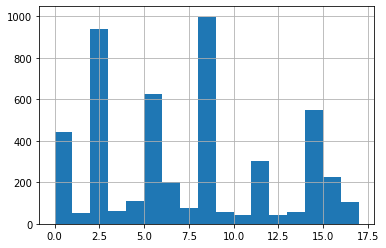

In [9]:
data.target.hist(bins=17)

In [12]:
(len(sequences_train),len(sequences_test))

(4888, 1223)

- We notice that the data is imbalanced.
- we have 18 class
- we have 4888 sequences for training set and 1223 for testing set 

Let's compute the mean and std of number o caracteres in each sequence 

In [17]:
mean_carr = np.mean(data.seq.apply(len))
std_carr = np.std(data.seq.apply(len))
print("mean", round(mean_carr,2), "and std is", round(std_carr,2))

mean 258.14 and std is 162.24


To handle the imbalancing of the target , (we have the majority class 0 is 100 times larger than minority class):
- we can oversample minority classes, using multiple good approaches depending on our needs like:
- random under sampling : reduce randomly majority classes to be almost close in counts to minority classes
- random over sampling : duplicate randomly minority classes to be almost close in counts to majority classes
- smote :  creates synthetic samples by selecting two or more nearest neighbors of a minority class instance, and then interpolating the feature values between those instances to create new, synthetic instances.
- adasyn : , adapts the synthetic sample generation process based on the density of the minority class. It creates more synthetic samples in the regions where the minority class is denser, and fewer synthetic samples in the regions where the minority class is sparser. This aims to balance the class distribution more effectively.
- Using F1 metric:  takes into account the model's ability to correctly identify both the majority and minority classes. If a model has a high F1 score, it means it has a good balance of precision and recall, and is able to correctly identify both the majority and minority classes.

- ** class weight **: this is the best approach when it's available, since it interfers directly into the loss function by giving to each class an imporatance score for it's contribution in loss function

    ==> we will use in the following the classes weights approach

### Important functions 

In [19]:
# numpy softmax function
def softmax(x):
    y = np.exp(x - np.max(x))
    f_x = y / np.sum(np.exp(x))
    return f_x


softmax_vect = np.vectorize(softmax)

In [57]:
# weighted multi-class log loss
from sklearn.metrics import log_loss


def weighted_mc_log_loss(y_true, y_pred, y_pred_proba):
    loss = log_loss(y_true, y_pred_proba, labels=np.unique(y_true))
    accuracy = (y_true == y_pred).sum() / len(y_true) * 100
    return print(f"loss = {loss:.2f} and accuracy",f"{accuracy:.2f}")


In [42]:
# submit function 
def submit(y_pred_proba,name=''):
    # Write predictions to a file
    with open(name+"sample_submission.csv", "w") as csvfile:
        writer = csv.writer(csvfile, delimiter=",")
        lst = list()
        for i in range(18):
            lst.append("class" + str(i))
        lst.insert(0, "name")
        writer.writerow(lst)
        for i, protein in enumerate(proteins_test):
            lst = y_pred_proba[i, :].tolist()
            lst.insert(0, protein)
            writer.writerow(lst)

### Split data

In [22]:
#  s^plit data into train, test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data,  # Features
    data.target.to_numpy(),  # Target variable
    test_size=0.2,  # 20% test size
)
X_train = X_train.reset_index(drop=True)  # we reste the indexes
X_test = X_test.reset_index(drop=True)

## Tf-idf

In [23]:
# Map sequences to
vec = TfidfVectorizer(analyzer="char", ngram_range=(1, 3))
X_train_tf = vec.fit_transform(X_train.seq)
X_test_tf = vec.transform(X_test.seq)
X_unseen = vec.transform(unseen.seq)
X_train_tf.shape

(3910, 8465)

In [24]:
# get the weight of each class
(unique, counts) = np.unique(y_train, return_counts=True)
class_weight = {uni: len(y_train) / count for uni, count in zip(unique, counts)}
# class_weight

we use the count of each unique class to weight the classes in the loss function 

### Logistic regression

In [27]:
# Setting up the model class
lr_model_tf = LogisticRegression(class_weight=class_weight, solver="liblinear")

# Training the model
lr_model_tf.fit(X_train_tf, y_train)

LogisticRegression(class_weight={0: 10.831024930747922, 1: 97.75,
                                 2: 5.213333333333333, 3: 85.0,
                                 4: 44.43181818181818, 5: 7.757936507936508,
                                 6: 24.285714285714285, 7: 67.41379310344827,
                                 8: 4.936868686868687, 9: 85.0, 10: 122.1875,
                                 11: 15.038461538461538, 12: 111.71428571428571,
                                 13: 79.79591836734694, 14: 9.178403755868544,
                                 15: 21.843575418994412, 16: 78.2,
                                 17: 118.48484848484848},
                   solver='liblinear')

In [32]:
## Calculate key performance metrics
test_pred_lr_proba = lr_model_tf.predict_proba(X_test_tf)
test_pred_lr = lr_model_tf.predict(X_test_tf)

# Print a classification report
print(
    classification_report(y_test, test_pred_lr)
)  # this threshold gives the best weighed average from the ROC curves

              precision    recall  f1-score   support

           0       0.70      0.73      0.72        79
           1       1.00      0.10      0.18        10
           2       0.53      0.71      0.60       189
           3       0.89      0.57      0.70        14
           4       0.92      0.50      0.65        24
           5       0.50      0.68      0.57       121
           6       0.75      0.44      0.55        41
           7       0.50      0.12      0.20        16
           8       0.66      0.71      0.69       206
           9       0.33      0.09      0.14        11
          10       0.00      0.00      0.00        11
          11       0.37      0.56      0.44        45
          12       1.00      0.22      0.36         9
          13       0.75      0.30      0.43        10
          14       0.60      0.49      0.54       122
          15       0.65      0.23      0.34        47
          16       0.75      0.30      0.43        10
          17       1.00    

In [58]:
weighted_mc_log_loss(y_test, test_pred_lr, test_pred_lr_proba)

loss = 1.79 and accuracy 58.38


### multinomial NB

In [59]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train_tf, y_train)

test_pred_nb_proba = nb.predict_proba(X_test_tf)
test_pred_nb = nb.predict(X_test_tf)

# Print a classification report
print(
    classification_report(y_test, test_pred_nb)
)  # this threshold gives the best weighed average from the ROC curves

              precision    recall  f1-score   support

           0       1.00      0.11      0.20        79
           1       0.00      0.00      0.00        10
           2       0.26      0.96      0.41       189
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        24
           5       1.00      0.08      0.15       121
           6       0.00      0.00      0.00        41
           7       0.00      0.00      0.00        16
           8       0.52      0.68      0.59       206
           9       0.00      0.00      0.00        11
          10       0.00      0.00      0.00        11
          11       0.00      0.00      0.00        45
          12       0.00      0.00      0.00         9
          13       0.00      0.00      0.00        10
          14       1.00      0.01      0.02       122
          15       0.00      0.00      0.00        47
          16       0.00      0.00      0.00        10
          17       0.00    

In [60]:
weighted_mc_log_loss(y_test, test_pred_nb, test_pred_nb_proba)

loss = 3.00 and accuracy 34.97


### SVC

In [61]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

svc_init = LinearSVC(class_weight=class_weight)
svc = CalibratedClassifierCV(svc_init)
svc.fit(X_train_tf, y_train)

CalibratedClassifierCV(base_estimator=LinearSVC(class_weight={0: 10.831024930747922,
                                                              1: 97.75,
                                                              2: 5.213333333333333,
                                                              3: 85.0,
                                                              4: 44.43181818181818,
                                                              5: 7.757936507936508,
                                                              6: 24.285714285714285,
                                                              7: 67.41379310344827,
                                                              8: 4.936868686868687,
                                                              9: 85.0,
                                                              10: 122.1875,
                                                              11: 15.038461538461538,
                                                              12: 111.71428571428571,
                                                              13: 79.79591836734694,
                                                              14: 9.178403755868544,
                                                              15: 21.843575418994412,
                                                              16: 78.2,
                                                              17: 118.48484848484848}))

In [62]:
test_pred_svc_proba = svc.predict_proba(X_test_tf)
test_pred_svc = svc.predict(X_test_tf)

# Print a classification report
print(
    classification_report(y_test, test_pred_svc)
)  # this threshold gives the best weighed average from the ROC curves

              precision    recall  f1-score   support

           0       0.73      0.68      0.71        79
           1       1.00      0.10      0.18        10
           2       0.51      0.75      0.60       189
           3       1.00      0.50      0.67        14
           4       1.00      0.58      0.74        24
           5       0.55      0.64      0.59       121
           6       0.87      0.49      0.62        41
           7       1.00      0.12      0.22        16
           8       0.64      0.80      0.71       206
           9       1.00      0.09      0.17        11
          10       0.00      0.00      0.00        11
          11       0.53      0.53      0.53        45
          12       1.00      0.56      0.71         9
          13       0.75      0.30      0.43        10
          14       0.60      0.50      0.55       122
          15       0.65      0.23      0.34        47
          16       0.75      0.30      0.43        10
          17       1.00    

In [63]:
weighted_mc_log_loss(y_test, test_pred_svc, test_pred_svc_proba)

loss = 1.40 and accuracy 60.74


In [28]:
submit(svc.predict_proba(X_unseen),"svc")

## Fasttext

In [67]:
# !wget https://github.com/facebookresearch/fastText/archive/v0.9.2.zip
# !unzip v0.9.2.zip


# # # if zip is already downloaded
%cd fastText-0.9.2
# for command line tool :
!make
# for python bindings :
!pip install .

%cd ..
clear_output()

In [69]:
import fasttext
import csv


# inverseEncodingFastext is mainly to inverse the encoding of the prediction from __label_X to X
def inverseEncodingFastext(text):
    return int(re.sub("__label__", "", str(text)))  # replace __label__ by nothing


inverseEncodingFastext_vet = np.vectorize(inverseEncodingFastext)

In [71]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
# randomly oversample the data in order to balance it
oversample = RandomOverSampler(sampling_strategy={k: max(counts) for k in unique})
X_over, y_over = oversample.fit_resample(X_train, y_train)
print(Counter(y_over))

Counter({2: 792, 5: 792, 6: 792, 13: 792, 8: 792, 7: 792, 14: 792, 15: 792, 16: 792, 11: 792, 0: 792, 3: 792, 9: 792, 17: 792, 4: 792, 1: 792, 12: 792, 10: 792})


In [72]:
# define and store fasttext initial data as the library requires
def labelFastText(dataframe, target, outputName, predictor="seq"):
    df = dataframe.copy()
    df["target"] = target.copy()
    df["fastText"] = df["target"].progress_apply(lambda x: "__label__" + str(x))
    df = df.dropna(subset=[predictor, "target"])
    df = df.reset_index(drop=True)  # reset index
    df[predictor] = df[predictor].progress_apply(lambda x: " ".join(list(x)))
    df[["fastText", predictor]].to_csv(
        (outputName + ".txt"),
        index=False,
        sep=" ",
        header=None,
        quoting=csv.QUOTE_NONE,
        quotechar="",
        escapechar=" ",
    )
    return df

In [73]:
train = labelFastText(X_over, y_over, "train")
test = labelFastText(X_test, y_test, "test")

  0%|          | 0/14256 [00:00<?, ?it/s]

  0%|          | 0/14256 [00:00<?, ?it/s]

  0%|          | 0/978 [00:00<?, ?it/s]

  0%|          | 0/978 [00:00<?, ?it/s]

In [101]:
# we train our model
model_fasttext = fasttext.train_supervised(
    "train.txt",
    wordNgrams=6,  # n word grams are two
    dim=100,  # dimension of embeeding vector or the hidden layer
    epoch=50,
    loss="softmax",  #we use hirarchical softmax for fast computation
)

Read 3M words
Number of words:  22
Number of labels: 18
Progress: 100.0% words/sec/thread:  430865 lr:  0.000000 avg.loss:  1.216084 ETA:   0h 0m 0s 36.6% words/sec/thread:  428541 lr:  0.063375 avg.loss:  2.064179 ETA:   0h 0m39s


In [102]:
results = model_fasttext.test("test.txt")
print(f"testing results for nature de prob are :{results}")

testing results for nature de prob are :(978, 0.4785276073619632, 0.4785276073619632)


In [105]:
# this function output the predicted labels
def predict_fasttext(text, model):
    prediction = model.predict(str(text))  # get the prediction of the model
    # return inverseEncodingFastext(prediction[0][0]) # getting prediction directly with 0.5 threshold
    return inverseEncodingFastext(prediction[0][0])

# this function predicts probabily for each label
def predict_fasttext_proba(text, model):
    prediction = model.predict(str(text), k=18)  # get the prediction of the model
    arr = np.asarray(prediction[0])
    ind = inverseEncodingFastext_vet(arr)
    ind = ind.argsort()

    return prediction[1][ind]

In [107]:
# we make our predictions
test_pred_fasttext = test.seq.progress_apply(
    lambda sent: predict_fasttext(sent, model_fasttext)
).to_numpy()
test_pred_fasttext_proba = np.stack(
    test.seq.progress_apply(lambda sent: predict_fasttext_proba(sent, model_fasttext))
)

  0%|          | 0/978 [00:00<?, ?it/s]

  0%|          | 0/978 [00:00<?, ?it/s]

In [108]:
set(list(test_pred_fasttext))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17}

In [109]:
print(
    classification_report(y_test, test_pred_fasttext)
)  # this threshold gives the best weighed average from the ROC curves

              precision    recall  f1-score   support

           0       0.46      0.71      0.56        79
           1       0.17      0.10      0.12        10
           2       0.53      0.50      0.52       189
           3       0.67      0.57      0.62        14
           4       0.62      0.54      0.58        24
           5       0.55      0.49      0.52       121
           6       0.43      0.78      0.56        41
           7       0.24      0.38      0.29        16
           8       0.70      0.45      0.55       206
           9       0.38      0.27      0.32        11
          10       0.00      0.00      0.00        11
          11       0.30      0.47      0.37        45
          12       1.00      0.44      0.62         9
          13       0.80      0.40      0.53        10
          14       0.43      0.43      0.43       122
          15       0.17      0.32      0.23        47
          16       0.60      0.30      0.40        10
          17       1.00    

In [110]:
weighted_mc_log_loss(
    y_test,
    test_pred_fasttext,
    test_pred_fasttext_proba,
)

loss = 1.75 and accuracy 47.85


#### fatstext embeeding then lightGbm

In [112]:
import fasttext
from sklearn.decomposition import PCA

from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN

fasttextModel =model_fasttext # fasttext.load_model("model_fastext.bin")  # 17000 item /sec


def filterXY(X, y, indexes):
    X = X[indexes]
    y = y[indexes]
    return X, y


class Classification:
    """Home made classification with and pycaret"""

    def __init__(self, X, y, vecW="fasttext"):
        self.X_ = X
        self.y_ = y
        self.vecW_ = vecW
        self.classesCountStart_ = Counter(self.y_)

        print("- " * 40)
        print(f"Classes are {self.classesCountStart_}")
        print("- " * 40)

    def sent2vec_(self, text):
        if self.vecW_ == "fasttext":
            return fasttextModel.get_sentence_vector(text)

    def fit(self, verbose=False):
        self.Xtok_, self.ytok_ = filterXY(
            self.X_, self.y_, self.X_.notna()
        )  # filter from nan values
        print("- " * 40)
        print("starting sent2vec ...")
        self.Xtok_ = self.X_.progress_apply(self.sent2vec_)
        print(" sent2vec done :)")
        print("- " * 40)
        if verbose:
            return self.Xtok_

    def transform(self, verbose=False):
        print("transformation from 1D to nD is done")
        self.Xtransformed_, self.Ytransformed_ = filterXY(
            self.Xtok_, self.ytok_, self.Xtok_.notna()
        )
        self.Xtransformed_ = np.stack(self.Xtransformed_)
        print("- " * 40)
        if verbose:
            return self.Xtransformed_

    def fitPca(self, n_components=100, verbose=True, pca=None):
        if not pca:
            self.pca_ = PCA(n_components=n_components)
            self.pca_.fit(self.Xtransformed_)
        else:
            print("old pca taken into consideration")
            self.pca_ = pca
        if verbose:
            print("the total ratio of explained variance is :")
            print(np.sum(self.pca_.explained_variance_ratio_))
            print("the cummulative sum of explained variance is :")
            print(np.cumsum(self.pca_.explained_variance_ratio_))
        print("- " * 40)
        return self.pca_

    def balance(self, algo="adasyn"):
        print("Banalancing data is starting  ...")
        if algo == "adasyn":
            self.Xtransformed_, self.Ytransformed_ = ADASYN(
                n_jobs=-1, sampling_strategy={k: max(counts) for k in unique}
            ).fit_resample(self.Xtransformed_, self.Ytransformed_)

        elif algo == "smote":
            self.Xtransformed_, self.Ytransformed_ = SMOTE(n_jobs=-1).fit_resample(
                self.Xtransformed_, self.Ytransformed_
            )

        print("Banalancing data with " + algo + "is Done :)")

    def todataFrame(self, withPca=False):
        # raise DeprecationWarning('to use pca you should call the function .fitPca, then assign True to withPca args')
        self.df_ = self.Xtransformed_
        if withPca and self.pca_:
            self.df_ = self.pca_.transform(self.df_)
        self.df_ = pd.DataFrame(self.df_)
        self.df_["label_orig"] = self.Ytransformed_
        print("- " * 40)
        print(f"shape of dataframe is {self.df_.shape}")
        self.classesCountEnd_ = Counter(self.df_["label_orig"])
        print(f"Classes in the end are {self.classesCountEnd_}")
        return self.df_

In [114]:
clf = Classification(X_train.seq, y_train, vecW="fasttext")
clf.fit()
clf.transform()
clf.balance(algo="smote")
# pca = clf.fitPca(
#     n_components=30, verbose=True
# )  # if you comment this you should comment [ to be commented 1]
X_train_embed = clf.todataFrame(
    # withPca=True
)  # [ to be commented 1]

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Classes are Counter({8: 792, 2: 750, 5: 504, 14: 426, 0: 361, 11: 260, 15: 179, 6: 161, 4: 88, 7: 58, 16: 50, 13: 49, 3: 46, 9: 46, 1: 40, 12: 35, 17: 33, 10: 32})
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
starting sent2vec ...


  0%|          | 0/3910 [00:00<?, ?it/s]

 sent2vec done :)
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
transformation from 1D to nD is done
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Banalancing data is starting  ...
Banalancing data with smoteis Done :)
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
shape of dataframe is (14256, 101)
Classes in the end are Counter({2: 792, 5: 792, 6: 792, 13: 792, 8: 792, 7: 792, 14: 792, 15: 792, 16: 792, 11: 792, 0: 792, 3: 792, 9: 792, 17: 792, 4: 792, 1: 792, 12: 792, 10: 792})


In [115]:
clf_unseen = Classification(X_test.seq, y_test, vecW="fasttext")
clf_unseen.fit()
clf_unseen.transform()
# clf_unseen.fitPca(pca=pca)

X_test_embed = clf_unseen.todataFrame(
    # withPca=True
)

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Classes are Counter({8: 206, 2: 189, 14: 122, 5: 121, 0: 79, 15: 47, 11: 45, 6: 41, 4: 24, 7: 16, 3: 14, 17: 13, 10: 11, 9: 11, 13: 10, 1: 10, 16: 10, 12: 9})
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
starting sent2vec ...


  0%|          | 0/978 [00:00<?, ?it/s]

 sent2vec done :)
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
transformation from 1D to nD is done
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
shape of dataframe is (978, 101)
Classes in the end are Counter({8: 206, 2: 189, 14: 122, 5: 121, 0: 79, 15: 47, 11: 45, 6: 41, 4: 24, 7: 16, 3: 14, 17: 13, 10: 11, 9: 11, 13: 10, 1: 10, 16: 10, 12: 9})


In [116]:
# get our embeeding 
y_train_embed = X_train_embed["label_orig"]
X_train_embed = X_train_embed[X_train_embed.columns.difference(["label_orig"])]
y_test_embed = X_test_embed["label_orig"]
X_test_embed = X_test_embed[X_test_embed.columns.difference(["label_orig"])]

In [121]:
!pip install catboost
# !pip install xgboost
# !pip install lightgbm
clear_output()

In [ ]:

from catboost import CatBoostClassifier

catboost = CatBoostClassifier(iterations=1000,
                           task_type="GPU",
                           devices='0:1',
                           loss_function= 'MultiClass',
                           class_weights=class_weight)
catboost.fit(X_train_embed,
      y_train_embed,
          use_best_model=True,eval_set=(X_test_embed,pd.to_numeric(y_test_embed)))
clear_output()

In [125]:
print("the best iteration is in ",catboost.get_best_iteration(), "which is under 1000 iteration that we made, so no overfitting")

the best iteration is in  0 which is under 1000 iteration that we made, so no overfitting


In [126]:
test_pred_lbg_proba = clf_lgb.predict_proba(X_test_embed)
test_pred_lbg = clf_lgb.predict(X_test_embed)

# Print a classification report
print(
    classification_report(y_test, test_pred_lbg)
)  # this threshold gives the best weighed average from the ROC curves

              precision    recall  f1-score   support

           0       0.11      0.09      0.10        79
           1       0.00      0.00      0.00        10
           2       0.20      0.28      0.23       189
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        24
           5       0.16      0.17      0.16       121
           6       0.09      0.05      0.06        41
           7       0.00      0.00      0.00        16
           8       0.23      0.28      0.25       206
           9       0.00      0.00      0.00        11
          10       0.01      0.09      0.02        11
          11       0.06      0.02      0.03        45
          12       0.00      0.00      0.00         9
          13       0.00      0.00      0.00        10
          14       0.14      0.09      0.11       122
          15       0.08      0.02      0.03        47
          16       0.00      0.00      0.00        10
          17       0.00    

In [127]:
weighted_mc_log_loss(y_test, test_pred_lbg, test_pred_lbg_proba)

loss = 3.02 and accuracy 15.64


As we can see , after taking the embeeding of the data using fasttext (word2vec) then fitting a catboost model. It appears that we get poor performance

**So untill now, the best approach is Tf-Idf followed by a linearSVC which gives almost 1.4 in log loss**